In [1]:
!pip install keras_tuner
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [2]:
# Import Library
import keras_tuner as kt

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from warnings import filterwarnings
filterwarnings('ignore')

SEED_VALUE=123
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [3]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# dataset_path to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Introduction***

The garment industry is a major source of jobs and exports in many countries. To meet production targets, factories must manage their operations and workers efficiently. In real factory settings, factors like the team, workday, style of clothing, and many otherd can affect how productive workers are. Understanding these can help improve performance. This study uses data from a garment factory to explore what influences employee productivity and how it can be increased.

In [6]:
# read dataset
df = pd.read_parquet("/content/drive/MyDrive/midterm/dataset_1B.parquet")
df

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2016-03-10,Quarter2,Wednesday,10,2.90,NaN,960,0,0.0,0,0,8.0,62.833
1193,2016-03-10,Quarter2,Wednesday,8,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1194,2016-03-10,Quarter2,Wednesday,7,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1195,2016-03-10,Quarter2,Wednesday,9,2.90,NaN,1800,0,0.0,0,0,15.0,50.589


1. Date
  * Type: DateTime
  * Description: Represents the recorded date of production.
  * Relevance: Used to extract temporal features like month, day of the week, and season for trend analysis.

2. Quarter
  * Type: Categorical (Encoded)
  * Description: Represents the quarter of the year (Q1, Q2, Q3, or Q4).
  * Relevance: Helps analyze seasonal variations in productivity.
3. Day
  * Type: Categorical (Encoded)
  * Description: The day of the week when productivity was recorded.
  * Relevance: Helps in identifying productivity patterns based on weekdays and weekends.
4. Team Code
  * Type: Integer (Encoded)
  * Description: A unique identifier for the team.
  * Relevance: To know productivity patterns based on their team.
5. SMV (Standard Minute Value)
  * Type: Float
  * Description: The time required (in minutes) to complete a specific task.
  * Relevance: A key factor in determining production efficiency.
5. Overtime
  * Type: Integer
  * Description: The total overtime (in minutes) logged by workers.
  * Relevance: Indicates the impact of additional working hours on productivity.
6. WIP (Work in Progress)
  * Type: Integer
  * Description: The number of products that are unfinished.
  * Relevance: Higher wip should correlate with low productivity score.
7. Incentive
  * Type: Integer
  * Description: Monetary incentives provided to workers.
  * Relevance: Helps analyze the effect of financial motivation on productivity.
8. Idle Time
  * Type: Integer
  * Desicription: The amount of time workers were idle, measured in minutes.
  * Relevance: Higher idle time should correlate with low productivity score.
9. Idle Men
  * Type: Integer
  * Desicription: The number of workers who were idle.
  * Relevance: Higher idle men should correlate with low productivity score.
10. Number of Style Changes
  * Type: Integer
  * Description: The number of times the garment style was changed during production.
  * Relevance: Frequent style changes may disrupt efficiency and reduce productivity.
11. Number of Workers
  * Type: Integer
  * Description: The total number of workers in a given production unit.
  * Relevance: Workforce size can influence overall productivity levels.
12. Productivity Score (output)
  * Type: Integer
  * Descirption: The productivity score of the team, measured as a percentage.

**Business Understanding**

In the garment industry, maximizing productivity is essential for efficiency and profitability. This analysis helps identify how various factors such as overtime, idle time, incentives, style changes, and team size, impact the overall productivity score. Temporal data like date, day, and quarter reveal trends across weekdays and seasons, while operational metrics such as SMV, WIP, and number of workers highlight workflow efficiency. Understanding these relationships enables better workforce management, effective incentive planning, reduced idle time, and smoother production flow, ultimately leading to improved productivity outcomes.

In [7]:
df.shape # 1197 rows 13 columns

(1197, 13)

# ***Exploratory Data Analysis***

**Checking for:**
1. Inconsinsistent/Incorrect Data Types
2. Missing Value
3. Outliers
4. Duplicate
5. Distribution

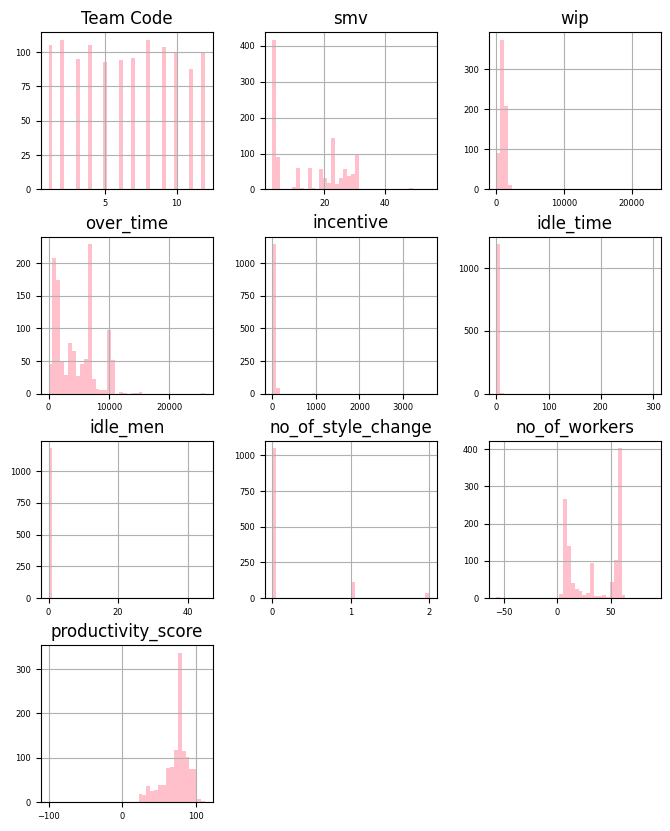

In [8]:
# finding the whole distribution before EDA
df.hist(figsize=(8, 10), bins=40, xlabelsize=6, ylabelsize=6, color='pink');

In a nutshell there are a couple things i notice:


*   There are negative value for no_of_workers and productivity_score
*   There are also clearly some outliers on many variables because the skewness are very visible
*   We also need to do scaling because some variable are bigger than other





## **Inconsistent/Incorrect Data Types**

In [9]:
df.info()
# there are missing value on variable 'wip'
# and there are 3 variable that needed to be get converted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


Next here im trying to convert the date and parse them based on year, month, and day to ensure the correlation among them with other variable.

In [10]:
# change date to day month and year
df['date'] = pd.to_datetime(df['date'], format = 'mixed')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [11]:
# dropping the 'date' because we aready extract manually
df = df.drop(labels=['date'], axis=1)

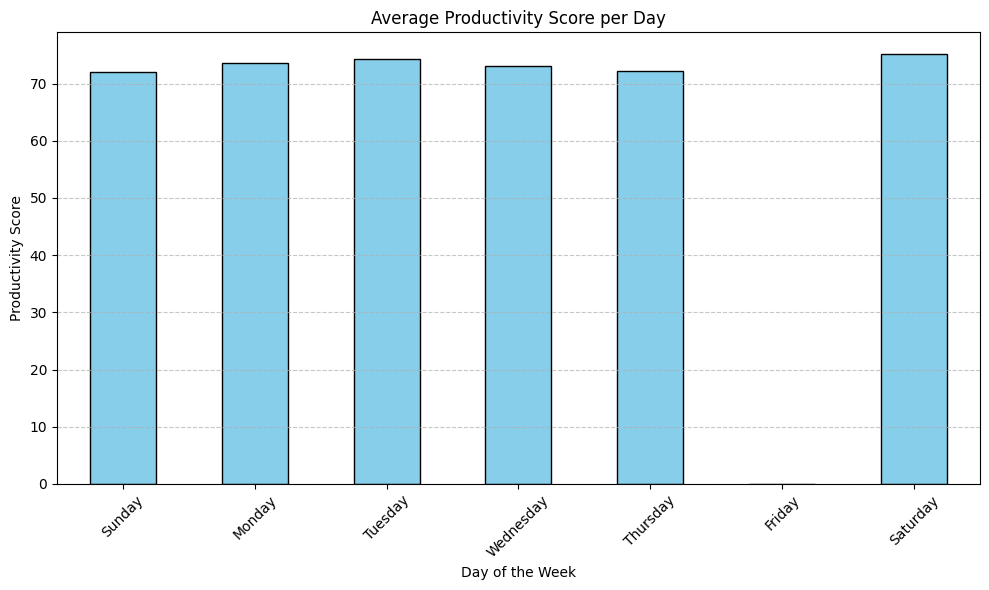

In [12]:
# put the day in order for better visuality
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df['day'] = pd.Categorical(df['day'], categories=weekday_order, ordered=True)

# group by day and calculate mean productivity score
grouped = df.groupby('day')['productivity_score'].mean().reindex(weekday_order)

plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Productivity Score per Day')
plt.xlabel('Day of the Week')
plt.ylabel('Productivity Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# there are no data on friday, maybe on friday they're not working at all, i mean we never know about the garment regulation in real life

In [13]:
df.head() # after converting it turns out the datetime variable itself JELEK

,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,month,year
0,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073,1,2015
1,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650,1,2015
2,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,2015
3,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057,1,2015
4,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038,1,2015


In [14]:
df['month'].value_counts()

,count
month,
1,542
2,451
3,204


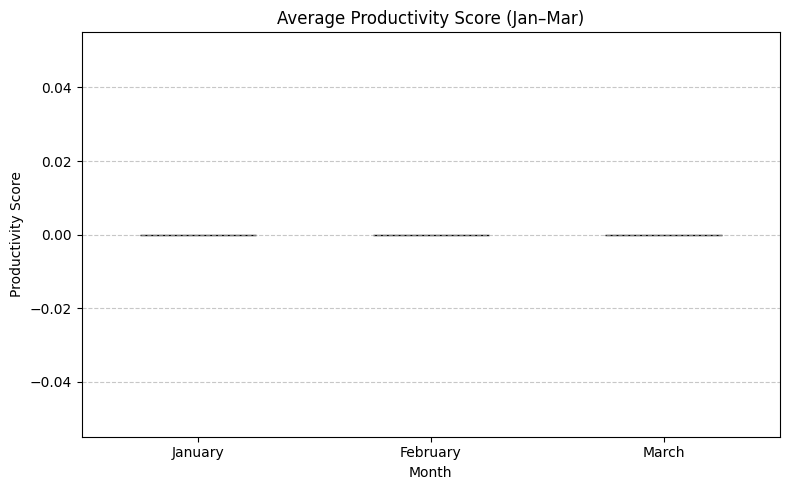

In [15]:
month_order = ['January', 'February', 'March']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# group by Month and compute average productivity score
monthly_avg = df.groupby('month')['productivity_score'].mean()
plt.figure(figsize=(8, 5))
monthly_avg.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Average Productivity Score (Jan–Mar)')
plt.xlabel('Month')
plt.ylabel('Productivity Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# you can see below the output is NON EXISTENT

So i think i wont even include the 'month' and 'year' in the model later on.

In [16]:
# when i see the histogram plot the variable 'no_of_workers'
# i found negative value there which is impossible for HUMAN to be negative
df[df['no_of_workers'] < 0]

,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,month,year
66,Quarter1,Monday,9,2.90,NaN,1920,0,0.0,0,0,-8.0,82.083,NaN,2016
79,Quarter1,Monday,3,19.87,944.0,6600,45,0.0,0,0,-55.0,75.024,NaN,2016
503,Quarter5,Thursday,6,2.90,NaN,1200,0,0.0,0,0,-10.0,89.900,NaN,2015
610,Quarter1,Wednesday,6,18.79,941.0,3360,30,0.0,0,0,-33.0,70.071,NaN,2015
697,Quarter2,Tuesday,2,22.52,1512.0,0,88,0.0,0,0,-57.0,89.998,NaN,2016


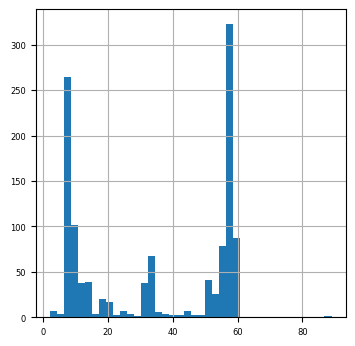

In [17]:
# change from negative to positive for column with no_of_workers which value < 0
df['no_of_workers'] = df['no_of_workers'].abs()

# histogram for only 'no_of_worker' to validate
df['no_of_workers'].hist(figsize=(4, 4), bins=40, xlabelsize=6, ylabelsize=6);

In [18]:
df[df['productivity_score'] < 0] # there are negative value also

,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,month,year
1120,Quarter2,Sunday,10,21.82,1335.0,6000,30,0.0,0,0,50.0,-100.0,NaN,2015


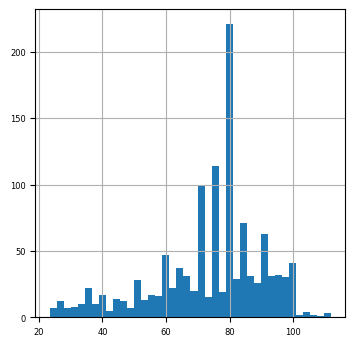

In [19]:
# unfortunately the 'productivity_score' variable also have negative value
# change from negative to positive for column with productivity_score which value < 0
df['productivity_score'] = df['productivity_score'].abs()

# histogram for only 'productivity_score' to validate
df['productivity_score'].hist(figsize=(4, 4), bins=40, xlabelsize=6, ylabelsize=6);

In [20]:
# find unique value of all variable

# for col in df.columns:
#     print(f'{col}: {df[col].unique()}')

# so to make the ouput minimal, so we dont have to scroll through
df['quarter'].unique()

# this variable i will encode later BUT FIRST THERE ARE ONLY 4 QUARTER
# other variable is all numerical so we dont have to change anything

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [21]:
df[df['quarter']=='Quarter5'] # approximately 30 data with Quarter

,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,month,year
498,Quarter5,Thursday,2,22.52,1416.0,6840,113,0.0,0,0,57.0,100.023,NaN,2015
499,Quarter5,Thursday,4,4.30,NaN,1200,0,0.0,0,0,10.0,98.900,NaN,2015
500,Quarter5,Thursday,3,22.52,1287.0,6840,100,0.0,0,0,57.0,95.019,NaN,2015
501,Quarter5,Thursday,4,22.52,1444.0,6900,88,0.0,0,0,57.5,90.080,NaN,2016
502,Quarter5,Thursday,10,22.52,1088.0,6720,88,0.0,0,0,56.0,90.013,NaN,2015
503,Quarter5,Thursday,6,2.90,NaN,1200,0,0.0,0,0,10.0,89.900,NaN,2015
504,Quarter5,Thursday,8,4.15,NaN,960,0,0.0,0,0,8.0,87.755,NaN,2015
505,Quarter5,Thursday,11,2.90,NaN,960,0,0.0,0,0,8.0,86.458,NaN,2015
506,Quarter5,Thursday,10,3.94,NaN,1200,0,0.0,0,0,10.0,85.695,NaN,2016
507,Quarter5,Thursday,1,3.94,NaN,1200,0,0.0,0,0,10.0,85.367,NaN,2015


In [22]:
# drop rows with quarter = 'Quarter5' because i think i can bare losing 30 data
df = df[df['quarter'] != 'Quarter5']

## **Check Duplicate**

In [23]:
# see if there is any duplicate value
df.duplicated().sum()
# there is no duplicate value so there is no redundancy

np.int64(0)

## **Missing Value**

In [24]:
# checking null value
df.isna().sum() # wip has 506 null values
# see the month is all missing value so i rhink we can drop it

,0
quarter,0
day,0
Team Code,0
smv,0
wip,485
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


'wip' is an important value so we cannot just drop them or just exclude the N/A. So we need to the computataion.

In [25]:
# df['wip'].unique()

In [26]:
# checking the skewness of 'wip'
df['wip'].skew()

# skewnes = 9.7418
# (+) means it right-skewed, long tail to the right
# so we do MEDIAN inputation

np.float64(9.592079763737514)

<Axes: ylabel='wip'>

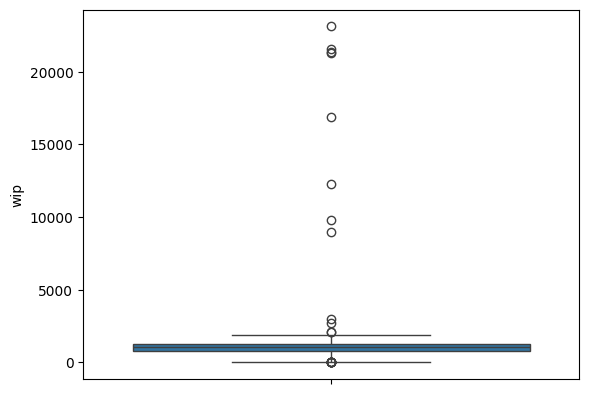

In [27]:
# checking outliers for 'wip' variable using boxplot
sns.boxplot(df['wip'])

In [28]:
# inpute median for missing value for 'wip' manually
df['wip'].fillna(df['wip'].median(), inplace=True)

In [29]:
df.isna().sum()

,0
quarter,0
day,0
Team Code,0
smv,0
wip,0
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


## **Handling Outliers**

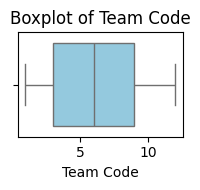

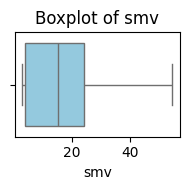

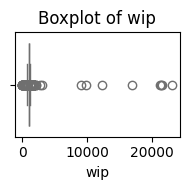

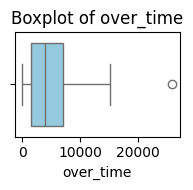

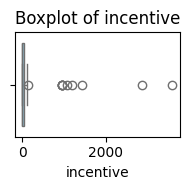

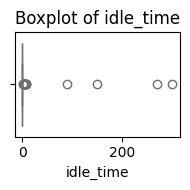

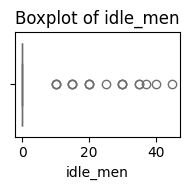

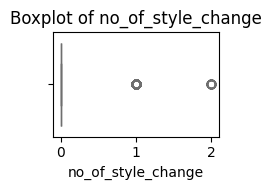

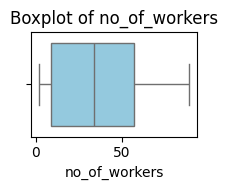

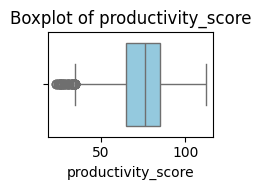

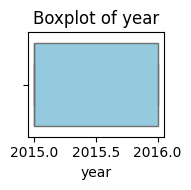

In [30]:
# boxplot for all numerical variable

# select only numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# plot each variable in a separate boxplot
for col in numerical_cols:
    plt.figure(figsize=(2, 2))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

For team code, we need to encode them later. Wip seems like so many outliers but it actually because we input with median.

In [31]:
# i think for some of the variable i might dot the winsorzing (over_time)
Q1 = df['over_time'].quantile(0.25)
Q3 = df['over_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# # outliers in variable 'over_time'
# outliers = df[(df['over_time'] < lower_bound) | (df['over_time'] > upper_bound)]

df['over_time'] = df['over_time'].clip(lower=lower_bound, upper=upper_bound)

In [32]:
df.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,year
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,6.426713,15.102368,1125.220295,4590.329575,38.402428,0.758023,0.383348,0.156114,34.722463,73.187478,2015.412836
std,3.459846,10.945789,1423.471030,3322.715201,163.014222,12.949387,3.330019,0.434912,22.160962,17.343545,0.492557
min,1.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,23.371000,2015.000000
25%,3.000000,3.940000,965.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,65.024000,2015.000000
50%,6.000000,15.260000,1035.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,75.927000,2015.000000
75%,9.000000,24.260000,1079.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,85.008000,2016.000000
max,12.000000,54.560000,23122.000000,15240.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,112.044000,2016.000000


## **Distribution**

In [33]:
df['Team Code'] = df['Team Code'].astype('str')

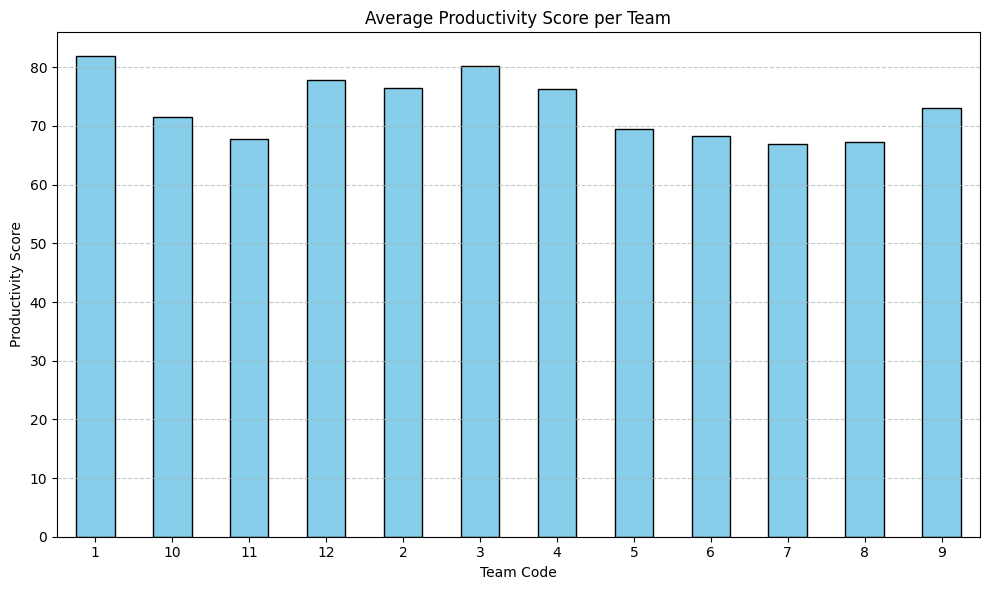

In [34]:
# is certain team is more productive?

grouped2 = df.groupby('Team Code')['productivity_score'].mean().sort_index()

plt.figure(figsize=(10, 6))
grouped2.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Productivity Score per Team')
plt.xlabel('Team Code')
plt.ylabel('Productivity Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

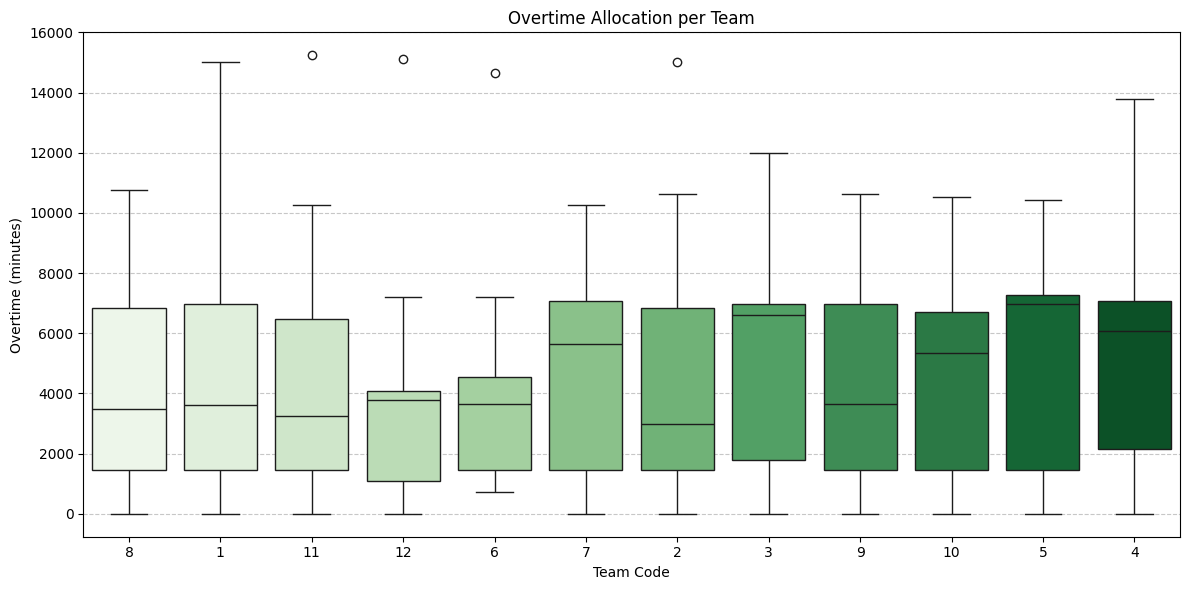

In [35]:
# any team work longer?
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team Code', y='over_time', data=df, palette='Greens')
plt.title('Overtime Allocation per Team')
plt.xlabel('Team Code')
plt.ylabel('Overtime (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Well the there is no certain team is more productive significantly with other.

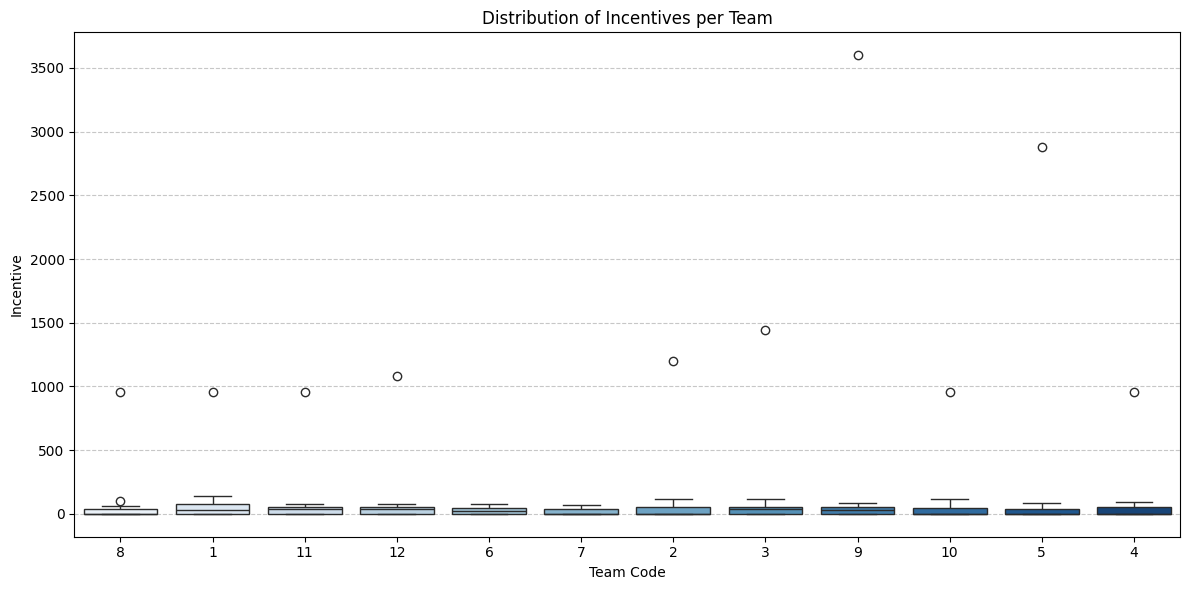

In [36]:
# the distribution of incentives and allocation of overtime for each team
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team Code', y='incentive', data=df, palette='Blues')
plt.title('Distribution of Incentives per Team')
plt.xlabel('Team Code')
plt.ylabel('Incentive')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

I dont handle the outliers because i dont know it just make sense for me

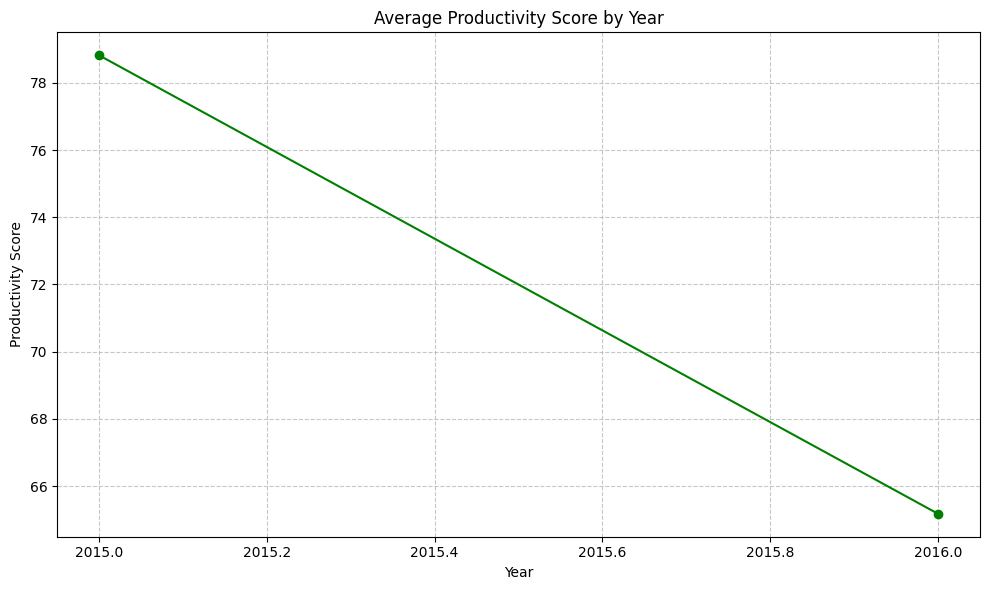

In [37]:
yearly_productivity = df.groupby('year')['productivity_score'].mean().reset_index()

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_productivity['year'], yearly_productivity['productivity_score'], marker='o', linestyle='-', color='green')
plt.title('Average Productivity Score by Year')
plt.xlabel('Year')
plt.ylabel('Productivity Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There are only year 2015 and 2016 and the over time (as year goes by) the garment industry has got lower productivity_score.

In [38]:
df.describe()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score,year
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,15.102368,1125.220295,4590.329575,38.402428,0.758023,0.383348,0.156114,34.722463,73.187478,2015.412836
std,10.945789,1423.471030,3322.715201,163.014222,12.949387,3.330019,0.434912,22.160962,17.343545,0.492557
min,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,23.371000,2015.000000
25%,3.940000,965.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,65.024000,2015.000000
50%,15.260000,1035.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,75.927000,2015.000000
75%,24.260000,1079.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,85.008000,2016.000000
max,54.560000,23122.000000,15240.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,112.044000,2016.000000


1. Productivity scores vary widely
  * The average productivity score is about 73.2, but it ranges from 23.4 to 112.0.
  * It shows significant differences in how productive different workers or teams are.
2. Overtime is common but not always used
  * The mean overtime is 4590 minutes, but the median is 3960, and some entries have zero overtime.
  * Some workers may regularly work overtime, while others may not possibly due to role, department, or demand.
3. Incentives are rare
  * The average incentive is around 38, but the median is 0, and 25% of workers receive no incentives at all.
  * Most workers don’t receive performance-based incentives, which could influence motivation.
  * (or like maybe this should be the main consideration for garment industry)
4. Idle time and idle workers are usually zero
  * The median and 75th percentile for both idle_time and idle_men are 0, suggesting idle time is rare but can be humm spike.
  * However, maximum idle time is 300 minutes, and idle_men can go up to 45.
5. Few style changes
  * On average, there are about 0.16 style changes, and most rows show zero changes.
  * This means most teams likely focus on one style during a work session, minimizing complexity.
6. Varying team sizes
  * The number of workers per team ranges from 2 to 89, with a mean of ~35 workers.
  * Larger teams may have different dynamics or productivity levels compared to smaller ones.
7. Work in progress (WIP) is highly variable
  * WIP values vary greatly, from 7 units to over 23,000, suggesting some teams or departments handle much larger workloads.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1153 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   quarter             1153 non-null   object  
 1   day                 1153 non-null   category
 2   Team Code           1153 non-null   object  
 3   smv                 1153 non-null   float64 
 4   wip                 1153 non-null   float64 
 5   over_time           1153 non-null   int64   
 6   incentive           1153 non-null   int64   
 7   idle_time           1153 non-null   float64 
 8   idle_men            1153 non-null   int64   
 9   no_of_style_change  1153 non-null   int64   
 10  no_of_workers       1153 non-null   float64 
 11  productivity_score  1153 non-null   float64 
 12  month               0 non-null      category
 13  year                1153 non-null   int32   
dtypes: category(2), float64(5), int32(1), int64(4), object(2)
memory usage: 115.3+ KB


In [40]:
df.isna().sum() # see the month actually no use at all
df = df.drop(labels=['month'], axis=1)

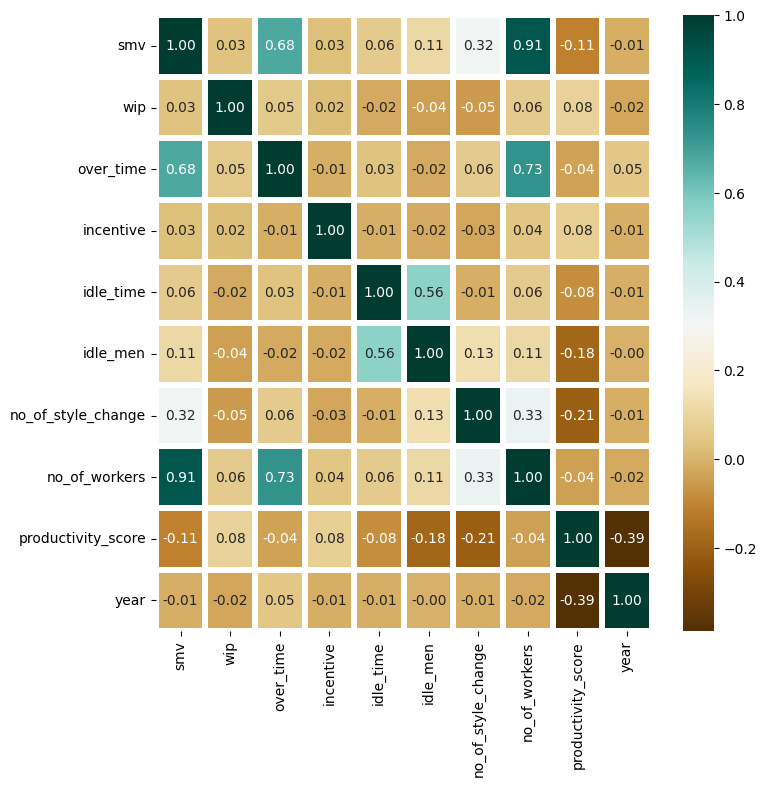

In [41]:
# looking for linearity
corr = df.select_dtypes(include=np.number).corr() # select only numerical attributtes
plt.figure(figsize = (8, 8))
sns.heatmap(corr, linewidths = 4, annot = True, fmt = ".2f", cmap="BrBG")
plt.show()

(+) correlation:
* incentive
* wip (well not as expected)

(-) correlation:
* smv = make sense because the one who need longer time to their job can be considered as NOT productive
* over_time = longer working hour may affect their productivity
* idle_time = many idle means theyre not productive
* idle_men
* no_of_style_change
* no_of_worker
* year

# ***Data Splitting***

In [42]:
inputDF = df.drop('productivity_score', axis=1)
outputDF = df['productivity_score']

In [43]:
x_train, x_test, y_train, y_test = train_test_split(inputDF, outputDF, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.125, random_state = SEED_VALUE)
print(f"Training size: {x_train.shape, y_train.shape}")
print(f"Validation size: {x_val.shape, y_val.shape}")
print(f"Test size: {x_test.shape, y_test.shape}")

Training size: ((806, 12), (806,))
Validation size: ((116, 12), (116,))
Test size: ((231, 12), (231,))


# ***Scalling***

In [44]:
# num = x_train.select_dtypes(include=['int64', 'float64']).columns
# cat = x_train.select_dtypes(include=['object']).columns

In [45]:
# numeric_cols = []
# categorical_cols = []
# for i in df.columns:
#     if "int" in str(x_train[i].dtype) or "float" in str(x_train[i].dtype):
#         numeric_cols.append(i)

#     elif df[i].dtype == 'object':
#         categorical_cols.append(i)

In [46]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# # df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [47]:
# scaler = StandardScaler()
# x_train_scaled_num = scaler.fit_transform(x_train[num])
# x_val_scaled_num = scaler.transform(x_val[num])
# x_test_scaled_num = scaler.transform(x_test[num])

# x_train_scaling = pd.DataFrame(x_train_scaled_num, columns=num, index=x_train.index)
# x_val_scaling = pd.DataFrame(x_val_scaled_num, columns=num, index=x_val.index)
# x_test_scaling = pd.DataFrame(x_test_scaled_num, columns=num, index=x_test.index)

# x_train_scaling = pd.concat([x_train_scaling, x_train[cat]], axis=1)
# x_val_scaling = pd.concat([x_val_scaling, x_val[cat]], axis=1)
# x_test_scaling = pd.concat([x_test_scaling, x_test[cat]], axis=1)

In [48]:
# numeric_cols.remove('productivity_score')

In [49]:
# from sklearn.preprocessing import StandardScaler

# numerical = ["quarter","day","smv","over_time","incentive","idle_time","idle_men","no_of_style_change","no_of_workers","productivity_score","month","year"]
# scaler = StandardScaler()
# df[numerical] = scaler.fit_transform(df[numerical])

In [50]:
# scaler = StandardScaler()
# x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
# x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
# x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

# ***Encoding***

In [51]:
# we need to manually encode the 'day'
df['day'] = df['day'].replace({'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6})
df['day'].value_counts()

,count
day,
3,208
0,203
2,201
1,199
4,179
6,163
5,0


In [52]:
# df.rename(columns={'Team Code': 'team_code'}, inplace=True)

In [53]:
# nominal columns to encode
nom_cols = ['quarter', 'Team Code', 'day']

# initialize OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# ===== Train =====
ohe_encoder.fit(x_train[nom_cols])  # Fit only on training data
train_encoded = ohe_encoder.transform(x_train[nom_cols])
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe_encoder.get_feature_names_out(nom_cols))
train_encoded_df.index = x_train.index  # Ensure same index
x_train = pd.concat([x_train.drop(nom_cols, axis=1), train_encoded_df], axis=1)

# ===== Validation =====
val_encoded = ohe_encoder.transform(x_val[nom_cols])
val_encoded_df = pd.DataFrame(val_encoded, columns=ohe_encoder.get_feature_names_out(nom_cols))
val_encoded_df.index = x_val.index
x_val = pd.concat([x_val.drop(nom_cols, axis=1), val_encoded_df], axis=1)

# ===== Test =====
test_encoded = ohe_encoder.transform(x_test[nom_cols])
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe_encoder.get_feature_names_out(nom_cols))
test_encoded_df.index = x_test.index
x_test = pd.concat([x_test.drop(nom_cols, axis=1), test_encoded_df], axis=1)


In [54]:
x_train.head() # checking to make sure

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,year,quarter_Quarter1,...,Team Code_6,Team Code_7,Team Code_8,Team Code_9,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
419,3.94,1035.0,1620,0,0.0,0,0,9.0,2015,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
978,27.48,609.0,6840,30,0.0,0,1,57.0,2016,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
488,29.12,1340.0,6960,63,0.0,0,0,58.0,2015,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
345,3.94,1035.0,1800,0,0.0,0,0,10.0,2016,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
969,3.94,1035.0,3360,0,0.0,0,0,8.0,2015,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# ***Tensor Dataset***

In [55]:
# convert data into TensorFlow format
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(buffer_size=len(x_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

In [56]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 31), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# ***Baseline Model***

Here on this study, we're trying to analyze 2 approach: sequential and functional.



The main difference between the Sequential and Functional models in Keras is on their flexibility and structure. The Sequential model is straightforward and linear, layers are added one after another, making it ideal for simple architectures where each layer has a single input and output. It’s easy to use and best suited for basic models like what we're doing now.



In contrast, the Functional model is more flexible and powerful, allowing the creation of complex architectures such as models with multiple inputs and outputs, branching layers, skip connections, and shared layers. This makes the Functional API more suitable for advanced neural network designs, like ResNet or Inception, where layers don’t follow a strictly linear flow.

## **Sequential**

In [57]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model_seq = tf.keras.Sequential(
    [
        Input(shape = (31,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]
)
model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

The first sequential model has 3 hidden layer, with 1 output layer for regression. Hidden layer: 128, 64, 32 with ReLu activation function.

ReLu is a linear activation function that exclude all negative value so that it keep the linear and non linearity of the data, that's why it is commonly used in the hidden layer. But the problem of ReLu arise when it create dead neuron, when the weight is negative and the output also become negative.

But it handles vanishing gradient well. Vanishing graient is when the gradient (used to update weight during backpropogration_ becomes very small as they go backward through layers, This makes learning slow or even causes the earlier layers to stop updateing entirely.

In [58]:
# x_train_scaling.shape[1] # input size (columns)

In [59]:
model_seq.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mean_squared_error", metrics = ['mean_absolute_error', 'mean_squared_error'])

So optimizer here helps the model learn by imporving its guesses step by step, so when the model makes a prediction, it checks how rong it is using the loss funcation. And then the optmizer ajust the model weight to imporve the next guess, and repeats until teh meodel gets better overtime.

For regression model, we use 3 common evaluation matrix:
1. **Rsquared**
  * R² tells us how well the model explains the variation in the target (actual) values.
  * It ranges from 0 to 1 (sometimes it can be negative if the model is really bad).
  * An R² of 1 means perfect prediction, while 0 means the model predicts no better than just guessing the average.
  * Ex: An R² of 0.85 means the model explains 85% of the variability in the data.
2. **Mean Absolute Error**
  * MAE is the average of the absolute differences between the predicted values and the actual values.
  * It tells you, on average, how much the predictions are off by.
  * Since it takes the absolute value, it doesn't care if the prediction is too high or too low, just how far off it is.
  * Ex: An MAE of 2.3 means the predictions are off by about 2.3 units on average.
3. **Mean Squared Error**
  * MSE is the average of the squared differences between predicted and actual values.
  * Unlike MAE, it squares the errors, so big errors count a lot more than small ones.
  * It’s useful when you want to penalize large errors more strongly.
  * Ex: A lower MSE means the model is predicting more accurately, but the scale can be larger due to squaring.

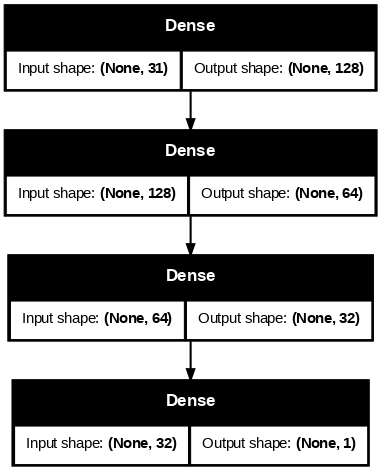

In [60]:
plot_model(model_seq,show_shapes=True, dpi=75)

In [61]:
history_seq = model_seq.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1)

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 57638.2266 - mean_absolute_error: 163.4954 - mean_squared_error: 57638.2266 - val_loss: 3166.4907 - val_mean_absolute_error: 28.4837 - val_mean_squared_error: 3166.4907
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2024.1306 - mean_absolute_error: 29.5330 - mean_squared_error: 2024.1306 - val_loss: 536.5179 - val_mean_absolute_error: 17.3070 - val_mean_squared_error: 536.5179
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 525.3878 - mean_absolute_error: 17.9211 - mean_squared_error: 525.3878 - val_loss: 565.0651 - val_mean_absolute_error: 16.3806 - val_mean_squared_error: 565.0651
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 394.9617 - mean_absolute_error: 15.2024 - mean_squared_error: 394.9617 - val_loss: 558.7302 - val_mean_absolute_error: 15.0943 - val_mean_squared_error: 558.7302
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 384.2999 - mean_absolute_error: 13.8966 - mean_

I know the minimum epoch is 10 but i use 250 because i want to see the convergency on later epoch. But what is epoch? so epcoh basicaly is one complete pass through the entire training dataset during model trainning (1 forwar pass + 1 backward pass). So the model updates its weights using backpropogation and an optimizer. Meanwhile batch size is the number of training sampels processes before updating the model's weights. For example here the batch size is 32 it means the model processes 32 samples then update weights.

In [62]:
y_pred_seq = model_seq.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


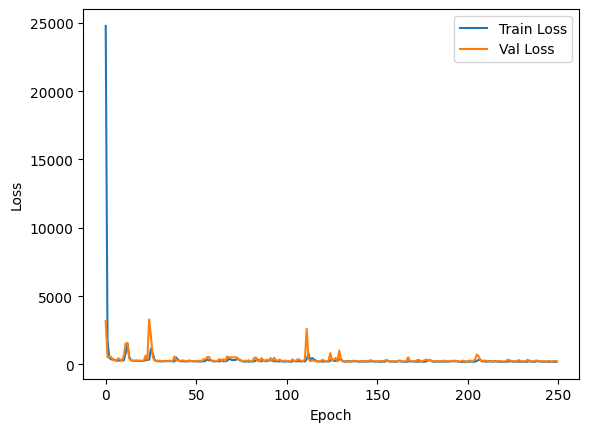

In [63]:
train_loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The plot shows that both train and validation loss drop a lot in the first few epochs, which might not be a good thing. This means the model is learning too quickly, and it could end up just memorizing the training data instead of learning patterns that work on new data. When this happens, the model might do well on training data but poorly on validation or test data. This fast drop can also mean the model is too complex or the learning rate is too high, causing it to settle too quickly without learning properly.

In [65]:
R2 = r2_score(y_test, y_pred_seq)
MAE = mean_absolute_error(y_test, y_pred_seq)
MSE = mean_squared_error(y_test, y_pred_seq)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.3159975990308648
Mean Absolute Error= 10.458305980071362
Mean Squared Error= 211.67508475199162


R2 = 0.31599 means that our model explains about 31.6% of the variation in the target variable. In other words, only around 1/3 of the changes in your actual data are being captured by the model, which is not very strong.

MAE = 10.4583 means that on average, our model predictions are off by about 10.46 units from the actual values (productiity socre). This gives a clear idea of the typical prediction error size, without caring whether the error is positive or negative.

MSE = 211.5740, so this is the average of the squared errors. Since errors are squared, this value is more sensitive to large mistakes. A higher MSE indicates the presence of some larger prediction errors. This also shows that the model might struggle with certain data points more than others.

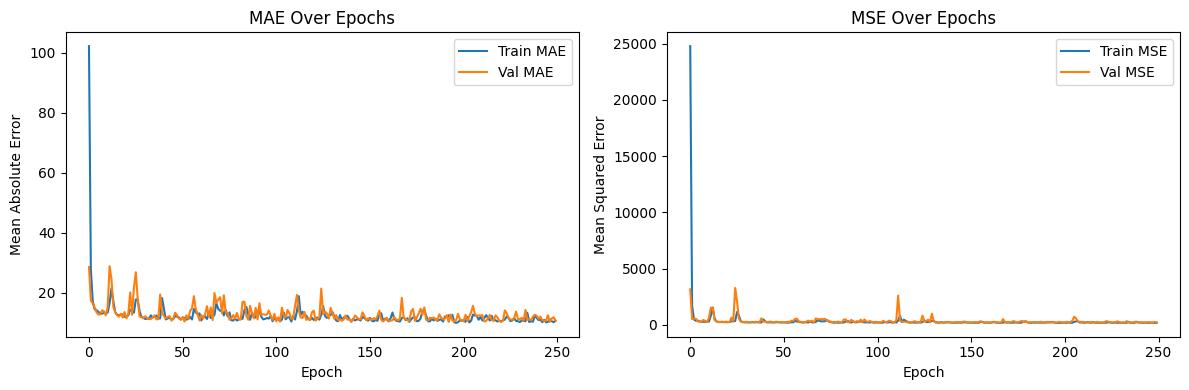

In [66]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_seq.history['mean_absolute_error'], label='Train MAE')
plt.plot(history_seq.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history_seq.history['mean_squared_error'], label='Train MSE')
plt.plot(history_seq.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## ***Functional***

Now after tyring the sequential model, we'll try the functional API approach.

In [67]:
inputs = Input(shape=(x_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)

model_func = Model(inputs=inputs, outputs=outputs)
model_func.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

For functional appoach I also use 3 hidden layer: 128, 64, 32. Also the ouput layer with linear regression model.

In [68]:
model_func.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

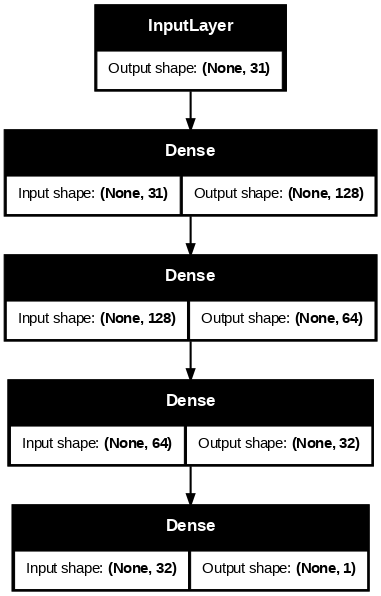

In [69]:
plot_model(model_func,show_shapes=True, dpi=75)

In [70]:
history_func = model_func.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1)

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 181392.8125 - mean_absolute_error: 278.5413 - mean_squared_error: 181392.8125 - val_loss: 3107.1929 - val_mean_absolute_error: 50.7091 - val_mean_squared_error: 3107.1929
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2175.8125 - mean_absolute_error: 33.2217 - mean_squared_error: 2175.8125 - val_loss: 524.8111 - val_mean_absolute_error: 16.2085 - val_mean_squared_error: 524.8111
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 616.6781 - mean_absolute_error: 17.3901 - mean_squared_error: 616.6781 - val_loss: 390.1461 - val_mean_absolute_error: 14.4514 - val_mean_squared_error: 390.1461
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 344.6578 - mean_absolute_error: 14.5498 - mean_squared_error: 344.6578 - val_loss: 393.0213 - val_mean_absolute_error: 13.7352 - val_mean_squared_error: 393.0213
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 324.1754 - mean_absolute_error: 13.5856 - mea

In [71]:
y_pred_func = model_func.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


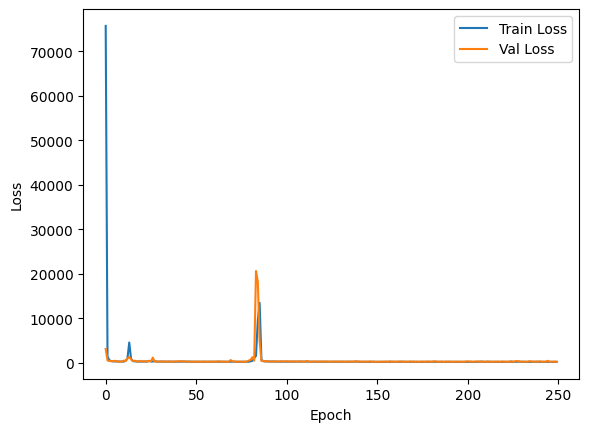

In [72]:
train_loss = history_func.history['loss']
val_loss = history_func.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The training loss (blue line) should decrease as the model learns from the data, while the validation loss (orange line) indicates how well the model generalizes to unseen data. Both train and validation loss drop significantly at the beginning and gradually converge, which is expected. However, we see that at around epoch 80, both training and validation loss suddenly increase, then go down again at around epoch 90. This shows that the model **may have experienced a temporary instability**, possibly due to a high learning rate or **some noisy data**. It could also indicate that the model briefly overfitted or got stuck in a bad spot before correcting itself. Such behavior might suggest the need for learning rate tuning or techniques like learning rate scheduling or early stopping to improve training stability.

In [73]:
R2 = r2_score(y_test, y_pred_func)
MAE = mean_absolute_error(y_test, y_pred_func)
MSE = mean_squared_error(y_test, y_pred_func)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.27319323968276044
Mean Absolute Error= 10.703353081244927
Mean Squared Error= 224.92155344848607


R2 = 0.2732 means that our model explains about 27.32% of the variation in the target variable. This is a bit lower than before, meaning the model is capturing less of the pattern in the data. It's still quite weak, suggesting that most of the variation in the actual values is not being explained by the model.

MAE = 10.7033 means that on average, your model's predictions are about 10.7 units off from the actual values. This is slightly worse than before (10.46), meaning the typical prediction error has increased a little.

MSE = 224.9215, this value has also increased from 211.68 to 224.92, which means your model is making larger errors overall, especially since MSE punishes big mistakes more heavily.

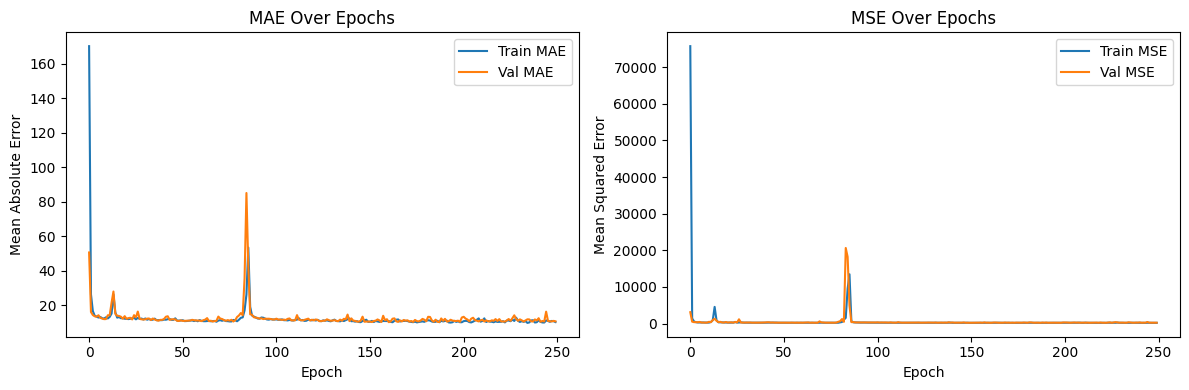

In [74]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_func.history['mean_absolute_error'], label='Train MAE')
plt.plot(history_func.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history_func.history['mean_squared_error'], label='Train MSE')
plt.plot(history_func.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## **Comparison between Baseline Model**

Both the functional and sequential models learned from the data too quickly, especially seen when the training and validation loss dropped sharply early on, it's a sign that they may have overfit the data. **Overfitting** happens when a model memorizes the training data instead of learning general patterns, which can lead to poor performance on new, unseen data.

Overall the sequential model performs better, it has a slightly higher R² (so it explains more variance), and both its average error (MAE) and squared error (MSE) are lower than the second model. This means the first model is more accurate and generalizes slightly better than the second one.

# ***Modified Model***

## **Sequential**

So after using ReLU in the baseline model, i noticed that the model might be learning too quickly or showing signs of instability or overfitting. Switching to ELU could be a good idea because ELU (Exponential Linear Unit) helps the model learn in a more stable way. ReLU sets all negative values to zero, which can cause some neurons to stop working during training. This makes it harder for the model to learn properly. ELU, on the other hand, allows small negative values, so more neurons stay active and keep learning. It also has a smoother curve than ReLU, which helps the model learn more steadily and avoid sudden jumps in training. Because of this, ELU can help the model train better, avoid overfitting, and sometimes reach better results, especially if ReLU makes the model learn too fast.

In [75]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

model_seq2 = Sequential([
    Input(shape=(31,)),

    Dense(128, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='elu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),

    Dense(1, activation='linear')
])

model_seq2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,201 (75.00 KB)

 Non-trainable params: 576 (2.25 KB)

So here i use ELu as the activation function of al the hidden layer. An then i also implement L2 regularization of 0.001. L2 regularization works by adding a penalty to large weights in the model, which helps prevent the model from relying too heavily on certain features and reduces the risk of overfitting. It encourages the model to keep the weights small and generalize better to new data.


Also, I include Batch Normalization after some layers. Batch normalization helps by standardizing the input to each layer, making the training faster and more stable. It also reduces the chances of the model getting stuck during training and can sometimes act like a regularizer, similar to dropout, helping to improve the model’s performance.










In [76]:
model_seq2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, clipnorm =1.0),
    loss = "mean_squared_error",
    metrics = ['mean_absolute_error', 'mean_squared_error'])

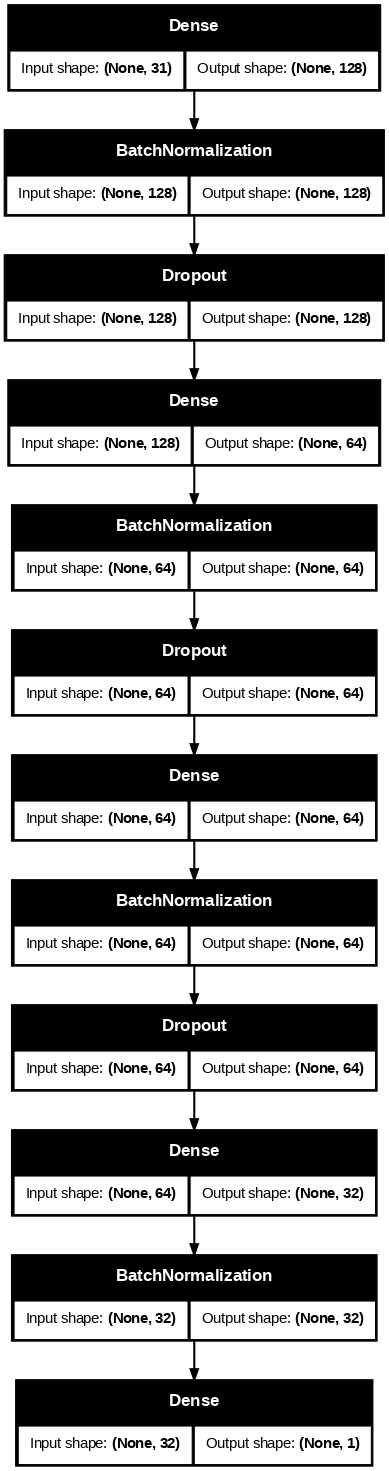

In [77]:
plot_model(model_seq2,show_shapes=True, dpi=75)

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=21, restore_best_weights=True)

# train the model
history_seq2 = model_seq2.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5676.4985 - mean_absolute_error: 73.2595 - mean_squared_error: 5676.2554 - val_loss: 4788.9961 - val_mean_absolute_error: 67.0793 - val_mean_squared_error: 4788.7549
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5702.9082 - mean_absolute_error: 73.2974 - mean_squared_error: 5702.6675 - val_loss: 4918.2432 - val_mean_absolute_error: 68.0637 - val_mean_squared_error: 4918.0044
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5636.2480 - mean_absolute_error: 73.0351 - mean_squared_error: 5636.0098 - val_loss: 4944.3081 - val_mean_absolute_error: 68.2853 - val_mean_squared_error: 4944.0732
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5766.5127 - mean_absolute_error: 74.0588 - mean_squared_error: 5766.2778 - val_loss: 4796.8643 - val_mean_absolute_error: 67.2061 - val_mean_squared_error: 4796.6309
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5685.6445 - mean_absolute_error: 73.600

Early stopping here **stops training the model when it’s no longer getting better** on the validation data. Instead of training for a fixed number of epochs, it watches the model's performance and stops when it sees that the validation loss has **stopped improving for a while**. This helps prevent the model from overfitting, which means learning the training data too well and doing poorly on new data. In short, early stopping helps the model **stay simple and generalize better**. (eppch stop at 73)

Patience = 10 means if the model doesn’t get better for 10 rounds in a row, it will stop. But if it improves again within those 10 epochs, the counter resets. This gives the model a chance to improve later instead of stopping too early.









In [79]:
y_pred_seq2 = model_seq2.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


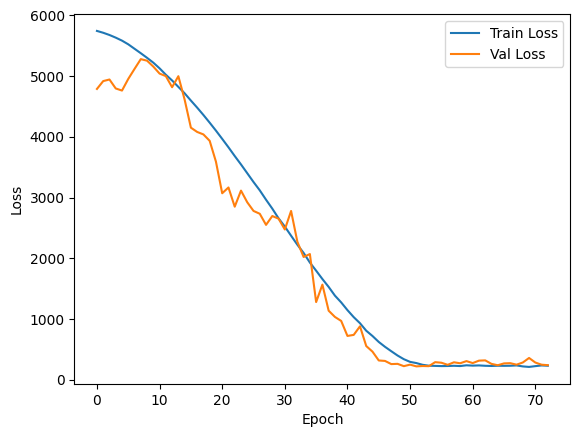

In [80]:
train_loss = history_seq2.history['loss']
val_loss = history_seq2.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model learns well in the beginning, but after about 20 epochs, it starts overfitting. This means it gets better at predicting the training data but performs worse on new data (validation data). The zigzag of the validation loss show divergency that is a sign of overfitting, the model is memorizing training data rather than generalizing to unseen data.

In [82]:
R2 = r2_score(y_test, y_pred_seq2)
MAE = mean_absolute_error(y_test, y_pred_seq2)
MSE = mean_squared_error(y_test, y_pred_seq2)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.18704930855182278
Mean Absolute Error= 12.7239957378437
Mean Squared Error= 251.58012057803882


R2 = 0.1870 means that our model explains about 18.7% of the variation in the target variable. This is quite low, indicating that the model is not capturing most of the patterns in the data, and its predictive power is weak.

MAE = 12.7239 means thaton average, the model’s predictions are off by about 12.72 units from the actual values. This shows a relatively large average error, meaning the model isn’t making very accurate predictions.

MSE = 251.5801 means that on average, the model's squared errors are 251.58. This metric is more sensitive to large errors, so this indicates that the model is making some larger prediction errors that are heavily affecting performance.

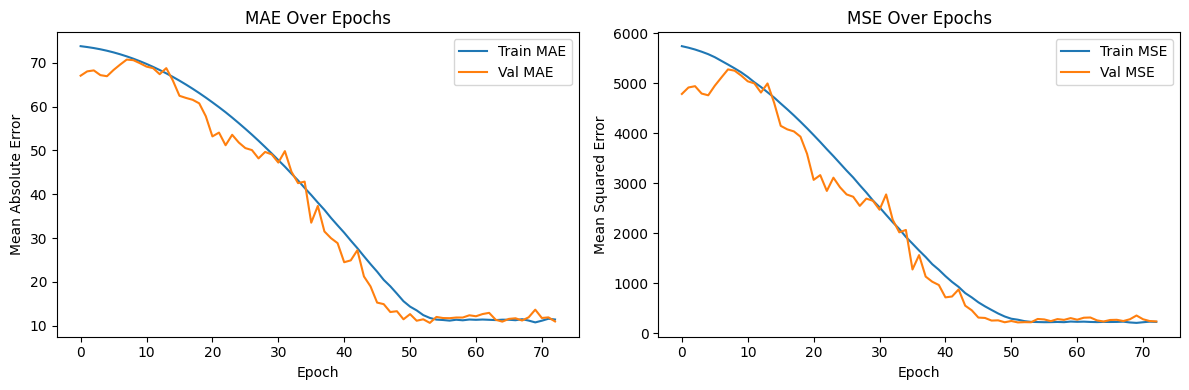

In [83]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_seq2.history['mean_absolute_error'], label='Train MAE')
plt.plot(history_seq2.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history_seq2.history['mean_squared_error'], label='Train MSE')
plt.plot(history_seq2.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

But as we see, converting the activation function in hidden layer using ELu actually make accuracy to goes lower, and with higher MAE too. So know i'm trying to go back using the baseline sequential model and do hyperparameter tuning to see if we could get a higher value.

In [101]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(31,)))

    # tune number of units in each Dense layer
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))

    # compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # we aim to minimize validation loss
    max_epochs=20,  # number of epochs for each trial
    hyperband_iterations=2,  # number of random search iterations
    directory='my_dir',  # directory to save results
    project_name='hyperparameter_tuning'
)

Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json


In [102]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# perform hyperparameter search with early stopping
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# get the optimal hyperparameters from the best trial
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:", best_hps.values)

# Optionally, you can retrieve and evaluate the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Trial 60 Complete [00h 00m 06s]
val_loss: 419.9283447265625

Best val_loss So Far: 249.7113037109375
Total elapsed time: 00h 09m 58s
Best Hyperparameters: {'units_1': 160, 'units_2': 32, 'units_3': 16, 'learning_rate': 0.0011598117931435517, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 35133.1758 - mae: 137.0191 - val_loss: 5826.7563 - val_mae: 62.3693
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3418.3862 - mae: 45.1210 - val_loss: 1033.2333 - val_mae: 25.8664
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 635.8181 - mae: 19.0240 - val_loss: 1540.8646 - val_mae: 17.2141
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 840.3384 - mae: 17.4327 - val_loss: 430.0671 - val_mae: 15.2716
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 337.5391 - mae: 13.9190 - val_loss: 963.9700 - val_mae: 15.2455
Epoch 6/50
21/21 ━━━━━━━━━━━━━

Test Loss: 383.16400146484375, Test MAE: 14.348480224609375

A loss of 383.16 could suggest that the model is not perfect at predicting the target variable, but it’s not extremely poor either. This number can vary based on the nature of the dataset we ue here and the range of values the model is predicting.

Soooooo it turns out after hyperparamter tuning, the 'best' model isnt the best at all :)


So we can say for sequentail approach, the baseline model is the best model so far. I know there must be something that i can do but maybe on another time, sorry.

## **Functional**

In [89]:
inputs = tf.keras.Input(shape=(31,))
dense1 = Dense(128, activation="relu")(inputs)
dense2 = Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.2),kernel_initializer=tf.keras.initializers.GlorotUniform(),
               bias_initializer=tf.keras.initializers.GlorotUniform())(dense1)
dense3 = Dense(32, activation="relu")(dense1)
cat_layer = tf.keras.layers.Concatenate(axis=1)([dense3,dense2])
out = Dense(1,activation='linear')(cat_layer)

model_func2 = Model(inputs=inputs, outputs=out)
model_func2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      4,096 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      4,128 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         97 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,577 (64.75 KB)

 Trainable params: 16,577 (64.75 KB)

 Non-trainable params: 0 (0.00 B)

Most of the modification are on the sencodn layer, in which the activation function used is Leaky ReLU. Leaky ReLU is similar to ReLU but allows a small, non-zero gradient when the input is less than 0. This is controlled by alpha=0.2, meaning when the input is negative, the output is scaled by 0.2. This helps prevent "dying ReLU" (where neurons don't activate at all).

The kernel initializer and bias initializer in this layer use GlorothUniform(also known as Xavier uniform initialization) to make sure that the initial weights are scaled correctly. It helps to prevent the network from vanishing or exploding gradients.

Initializer istelf is the formulato determine initial wight and bias it could be normal or uniform distribution

In [90]:
model_func2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [91]:
model_func2.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mean_squared_error", metrics = ['mean_absolute_error', 'mean_squared_error'])

In [92]:
history_func2 = model_func2.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=250,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 90925.0078 - mean_absolute_error: 226.8912 - mean_squared_error: 90925.0078 - val_loss: 15065.8828 - val_mean_absolute_error: 92.1648 - val_mean_squared_error: 15065.8828
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9900.3799 - mean_absolute_error: 70.9521 - mean_squared_error: 9900.3799 - val_loss: 6019.6870 - val_mean_absolute_error: 49.6581 - val_mean_squared_error: 6019.6870
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2650.3669 - mean_absolute_error: 35.5354 - mean_squared_error: 2650.3669 - val_loss: 621.3294 - val_mean_absolute_error: 20.7924 - val_mean_squared_error: 621.3294
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 609.1053 - mean_absolute_error: 18.8507 - mean_squared_error: 609.1053 - val_loss: 468.5854 - val_mean_absolute_error: 16.3700 - val_mean_squared_error: 468.5854
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1079.0105 - mean_absolute_error: 19.3691

With early stopping the model has converge at 62.

In [93]:
y_pred_func2 = model_func2.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


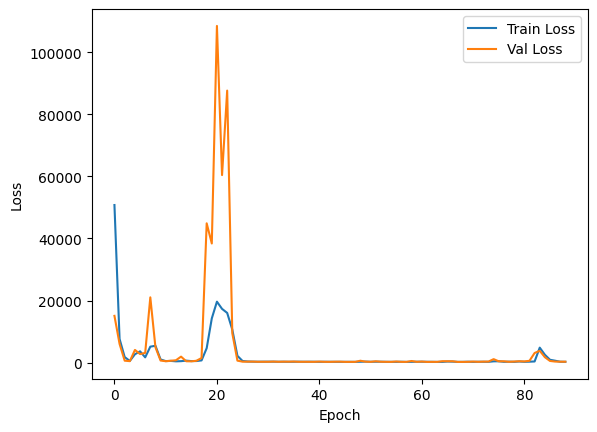

In [94]:
train_loss = history_func2.history['loss']
val_loss = history_func2.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model is learning but may be underfitting, because t just start to converge at around 35. But the peak of validation loss which increase significantly shows the model may be starting to overfit the training data. This means it's learning patterns that are too specific to the training set and not generalizing well to unseen data.

In [95]:
R2 = r2_score(y_test, y_pred_func2)
MAE = mean_absolute_error(y_test, y_pred_func2)
MSE = mean_squared_error(y_test, y_pred_func2)

print("R² Score=", R2)
print("Mean Absolute Error=", MAE)
print("Mean Squared Error=", MSE)

R² Score= 0.2713228258134416
Mean Absolute Error= 11.578560617818463
Mean Squared Error= 225.50038184696595


R2 = 0.27132 means that our model explains about 27.13% of the variation in the target variable. In other words, a significant portion of the data (over 70%) is unexplained by the model. This is relatively low and indicates that the model isn’t doing a great job at capturing the patterns in the data. Ideally, we want the R² score to be as close to 1 as possible, with higher values indicating better predictive performance.

MAE = 11.5785 means that on average, the model’s predictions are off by about 11.57 units from the actual values.

MSE = 225.5003 indicates that the model’s predictions have considerable deviations from the actual values, but this is not an extremely large error compared to other models. Since MSE is sensitive to outliers, this value could be influenced by any large prediction errors.

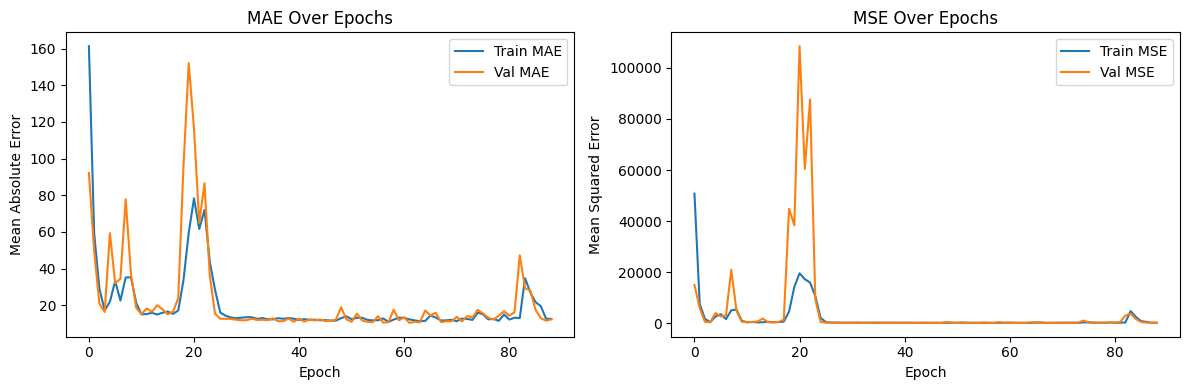

In [96]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_func2.history['mean_absolute_error'], label='Train MAE')
plt.plot(history_func2.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(history_func2.history['mean_squared_error'], label='Train MSE')
plt.plot(history_func2.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# ***Overal Conclusion***


The goal of this study is to estimate the porcutivity socre for each team in a garment factory, after doing all the data cleaning, EDA, encoding, scalling and many else, i can say that the dataset itself contain a lot of noisy data, and incomplete information.

Overal, the best model with the best rest of Rsquared and MAE is the sequntial baseline model. So i can honestly say that i failed to find the best modification of the model here.


# ***Video***

https://drive.google.com/drive/folders/1lbl4Ftap4BrcLyXtBPvsG7vd1k5KegfK?usp=sharing